In [251]:
import pdb, sys, numpy as np, pickle, os
import cairo
import networkx as nx
from igraph import *
from matplotlib import pyplot as plt
from scipy.spatial import distance

# fn = 'graph_clusters_30m_bos.pk'
# with open(fn,'rb') as f:
#     G = pickle.load(f)

In [189]:
'''
This code snippet loads various utility functions
'''



'''
Makes an igraph Graph object from a list of vertices and a list of corrdinates of each vertex

inputs: 
edges: list of tuples (i,j) where i, j are vertices with an edge
positions: list of tuples (x,y) where x,y are cartesian coordinates

output: an igraph Graph object, where the weight of each edge is the euclidean distance between its nodes
'''
def make_graph(edges, positions):
    G = Graph(edges)
    G.vs['pos']=positions
    G.es['weight']=[distance.euclidean(G.vs['pos'][i[0]], G.vs['pos'][i[1]]) for i in edges]
    G.vs['names']=[str(i) for i in G.vs.indices]               # vertex index
    G.es['names']=[str(np.round(i,2)) for i in G.es['weight']] # for plotting distance
    return G

'''
Returns the length of path links in a graph
'''
def get_link_lengths(G, path):
    return [distance.euclidean(G.nodes[path[i]]['pos'], G.nodes[path[i+1]]['pos']) for i in range(len(path)-1)]

'''
Converting a nx.Graph object to igraph.Graph
'''
def convert_to_nx(G):
    nx_G = nx.Graph(G.get_edgelist())
    for n in nx_G.nodes:
        nx_G.nodes[n]['pos'] = G.vs['pos'][n]
    for e in nx_G.edges:
        nx_G[e[0]][e[1]]['weight'] = G.es.find(_between = ((e[0],),(e[1],)))['weight']
    return nx_G

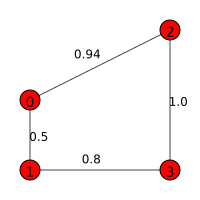

In [292]:

''' 
Testing that utils work,
by building a simple polygon 
'''

vertex_links= [(0,1),(0,2),(2,3),(1,3)]                    # each pair is a connections between nodes, nodes are indexed as 0,1,2,3
vertex_coords= [(0.2,0.5),(0.2,1),(1,0),(1,1)]             # each pair is coordinates of a node
G_quad = make_graph(vertex_links, vertex_coords)      # this also assigns distances to each edge
plot(G_quad, layout = vertex_coords, vertex_label=G_quad.vs['names'], edge_label=G_quad.es['names'],margin=30, bbox=(200,200))


In [214]:
'''
Test and demo of the networkx functionality:
'''

'''
Generate all simple paths in the graph from source to target. A simple path is a path with no repeated nodes.
'''

nx_G = convert_to_nx(G_quad)
start_node = 0;
end_node = 1;

path_set = list(nx.all_simple_paths(nx_G,           # input graph
                                    start_node,     # index of the start node
                                    end_node))      # index of the end node 

print ('all possible paths between nodes 0 and 1: ' , path_set)

links_lenths  = [get_link_lengths(nx_G, path) for path in path_set]  # calculates the distances between each pair of
                                                                     # nodes in the returned path
print ('path link lengths in each path: ' , links_lenths)
print ('total length of each path: '      , [sum(i) for i in links_lenths])
print ('\n\n')



''' 
We can generate only paths that are shorter than a certain length by using the cutoff argument: 
For example:  
'''

path_set = list(nx.all_simple_paths(nx_G,           # input graph
                                    start_node,     # index of the start node
                                    end_node,       # index of the end node 
                                    cutoff=2))

print ('all possible paths between nodes 0 and 1, that are shorter than 2: ' , path_set)
links_lenths  = [get_link_lengths(nx_G, path) for path in path_set]
print ('total length of each path: ' , [sum(i) for i in links_lenths])
print ('\n\n')

'''We will use the cutoff argument to restrict the subset of paths that we are fitting by the model later on'''

'''We will assume that people will consider a subset of paths that is not longer than:

   (a) x times the euclidian distance between source and traget (assume x=2), or
   
   (b) X times the shortest possible path (assume x=1.5) 
   
   Thus, we assume that most folks are familliar with the map, have a reasonable estimate of the
   length of the direct path, and would not take a path that is x times as long, even if the direct 
   path was maximally aversive
'''
       
'''Method (a)''' 

cutoff = distance.euclidean(nx_G.nodes[0]['pos'], nx_G.nodes[1]['pos']);
print ('Euclidian distance between the source and target: ' , cutoff)

path_set = list(nx.all_simple_paths(nx_G,           # input graph
                                    start_node,     # index of the start node
                                    end_node,        # index of the end node 
                                    cutoff=cutoff*2))

print ('all possible paths between nodes 0 and 1, that are shorter than twice the euclidian distance, ', cutoff*2, ': ' , path_set)
links_lenths  = [get_link_lengths(nx_G, path) for path in path_set]
print ('total length of each path: ' , [sum(i) for i in links_lenths])
print ('\n\n')


''' Now refine the subset restriction by Method (b) '''

''' 
In this case networkx fails and returns no paths, 
even through there is a path shorter than the requested length.

Just flagging the limitations of the package, and that to use it we would have to set generous cutoffs
'''


shortest_path_len = min([sum(i) for i in links_lenths]);

path_set = list(nx.all_simple_paths(nx_G,            # input graph
                                     start_node,      # index of the start node
                                     end_node,        # index of the end node 
                                     cutoff=shortest_path_len*1.5))

print ('all possible paths between nodes 0 and 1, that are shorter than 1.5 times the shortest path, ', 
        shortest_path_len*1.5, ': ' , path_set)

links_lenths  = [get_link_lengths(nx_G, path) for path in path_set]
print ('total length of each path: ' , [sum(i) for i in links_lenths])


all possible paths between nodes 0 and 1:  [[0, 1], [0, 2, 3, 1]]
path link lengths in each path:  [[0.5], [0.9433981132056605, 1.0, 0.8]]
total length of each path:  [0.5, 2.743398113205661]



all possible paths between nodes 0 and 1, that are shorter than 2:  [[0, 1]]
total length of each path:  [0.5]



Euclidian distance between the source and target:  0.5
all possible paths between nodes 0 and 1, that are shorter than twice the euclidian distance,  1.0 :  [[0, 1]]
total length of each path:  [0.5]



all possible paths between nodes 0 and 1, that are shorter than 1.5 times the shortest path,  0.75 :  []
total length of each path:  []


In [299]:
'''
Number of Nodes and Distance Hypothesis: 
people minimise both the distance travelled and the number of nodes in the path.
'''

'''
    Chooses a path from start to end node in a given graph, 
    taking into account the number of nodes in the path and the total length of the path
    
    Inputs: G:              An igraph Graph object with properties 'pos' and 'weight'
            W_nodes:        weighting the preference for fewer nodes vs. path length
            
                            0 <= W_nodes <= 1
                            W_nodes = 0: returns the path with fewest nodes
                            W_nodes = 1: returns the sortest path
                     
            start_node:     start node, sourse
            end_node:       end node, target
   
    Outputs: path with the lowest score and its length
    
'''

def path_distances(nx_G, paths):
    links_lenths  = [get_link_lengths(nx_G, path) for path in paths]
    # print ('Debug: link lengths: '  , links_lenths)
    
    return [sum(i) for i in links_lenths]

def choosePath_by_distance_and_NumberOfNodes(nx_G, paths, start_node, end_node, W_nodes):
    
    distances = path_distances(nx_G, paths)
    node_num  = [len(paths[i]) for i in range(len(paths))]
    
    print ('path distances: '  , distances)
    print ('number of nodes: ' , node_num)
    
    cost =  W_nodes * np.array( node_num  )          # cost based on the number of nodes - more nodes - higher cost                                           
    cost =  cost + (1-W_nodes) * np.array(distances) # cost based on distances - longer path - higher cost
    # print ('Debug: path scores:    ' , cost)
    
    best_path = paths[np.argmin(cost)]
    return  best_path, sum(get_link_lengths(nx_G, best_path))


In [313]:
'''
Intermediate Node Proximity Hypothesis: when choosing a path among a set of alternatives people evaluate 
intermediate path nodes, preferring nodes closer to final goal at each decision point

This is a basic version, where we do not care how many nodes there are in the path, and how long the path is, 
but simply consider the nodes one by one, at each decision going to whichever node is the closest to our final destination
We will continue to develop a more realistic model below.

More realistically, we'd like all the factors - 
(1) total distance, (2) number of nodes, (3) intermediate proximity and (4) landmark density -
to factor in the model that assigna value to the path

This block of code applies the Intermediate Node Proximity hypothesis to the above example, 
and prints out the chosen path, which should be: 0, 1, 3
'''

def path_proximity_value(gamma, node_proximity):
    
    # evaluate each path based on intermedite nodes, and choose the path for which the value is minimised 
    # we will use a simple discounted utility: v(p) = proximity(p[0]) + gamma*proximity(p[1])+gamma^2*proximity(p[2])...

    val = 0
    for i in range( len(node_proximity) ) :
        val = val + gamma**i * node_proximity[i]
    return val

def path_proximities(nx_G, path_set, start_node, end_node) :
    
    # Calculate proximities of each inetrmediate node to the end goal.
    # Note that the node zero in each path is identical to the starting node, 
    # so we do not calculate the initial distance   
    
    proximities =  [ [distance.euclidean( nx_G.nodes[path_set[j][i]]['pos'], end_goal) for i in range(1,len(path_set[j])-1)]  for j in range(len(path_set))]

    #print('Debug: node proximities to the goal, for each path',  proximities) 

    # make the arrays the same length, by paddingthe shorther arrays with 0

    l = [len(proximities[i])  for i in range(len(proximities))]
    pad_length = max(l)

    for i in range(len(proximities)):
       for j in range(len(proximities[i]), pad_length):
           proximities[i] = np.append(proximities[i],0)
    
    #print('Debug: padded proximity arrays',  proximities) 
    return proximities
    
def choosePath_by_Intermediate_Node_Proximity(nx_G, path_set, start_node, end_node, gamma) : 
    
    # Calculate proximities of each inetrmediate node to the end goal
    proximities = path_proximities(nx_G, path_set, start_node, end_node)
    
    # assign a value to each path based on a discounted sum of node proximities
    values = [  path_proximity_value(gamma, proximities[i]) for i in range(len(proximities)) ]
    
    # best path index, which mimimises the value function
    return np.argmin(values), min(values)   


In [314]:
''' Distance, Number of Nodes, and Intermediate Node Proximity '''
''' The relative weights of nodes, distance, and proximity will be normalised and treated as percents'''

def choosePath_by_Nodes_Distance_And_Intermediate_Node_Proximity(nx_G, path_set, start_node, end_node, W_nodes, W_distance, W_proximity, gamma) :
   
   coefs = [W_nodes, W_distance, W_proximity]
   norm = [float(i)/sum(coefs) for i in coefs]                  # Normalised model coefficients
       
   distances = path_distances(nx_G, path_set)                   # potentailly could also discount future distances
   node_num  = [len(path_set[i]) for i in range(len(path_set))]
   
   proximities = path_proximities(nx_G, path_set, start_node, end_node)
   proxvals = [  path_proximity_value(gamma, proximities[i]) for i in range(len(proximities)) ]
   
   values =  norm[0] * np.array( node_num  )                    # more nodes - higher cost                                           
   values =  values + norm[1] * np.array( distances )
   values =  values + norm[2] * np.array( proxvals )
   return np.argmin(values), min(values) 

path set: [[0, 1, 3], [0, 2, 3], [0, 4, 5, 3]]
end goal (1, 3)


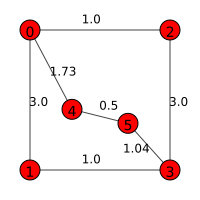

In [315]:
'''
Prepare another graph example.
A simple quad graph, but this time with a diagonal path connecting the opposite ends
'''

nodes       = [(0,1),(0,2),(2,3),(1,3),(0,4),(4,5),(5,3)]
coords      = [(0,0),(0,3),(1,0),(1,3),(0.3,1.7),(0.7,2)]
start_node  = 0
end_node    = 3

G_rect      = make_graph(nodes, coords)
nx_G_rect   = convert_to_nx(G_rect)                                 # converting the igraph object to a networkx object
end_goal    = nx_G_rect.nodes[end_node]['pos']
path_set    = list(nx.all_simple_paths(nx_G_rect, start_node, end_node)) # In this primitive example 
                                                                         # we consider path set as all possible paths 
                                                                         # but please use the cutoff parameter on a real dataset
print('path set:', path_set)
print('end goal' , end_goal)

plot(G_rect, layout = coords, vertex_label= G_rect.vs['names'], edge_label=G_rect.es['names'], margin=30, bbox=(200,200))



prioritising distance: 
path distances:  [4.0, 4.0, 3.270298301054262]
number of nodes:  [3, 3, 4]
best path from  0  to  3 : ([0, 4, 5, 3], 3.270298301054262)



prioritising number of nodes: 
path distances:  [4.0, 4.0, 3.270298301054262]
number of nodes:  [3, 3, 4]
best path from  0  to  3 : ([0, 1, 3], 4.0)



prioritising intermediate nodes with a discount rate :  0.9
best path based on node proximities path:  [0, 1, 3] with proximity value  1.0



best path based on the combination heuristic: [0, 1, 3] with value  3.2727272727272725





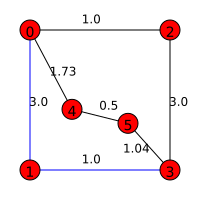

In [325]:
'''
Test choosePath_by_distance_and_NumberOfNodes on nx_G_rect
'''

print ('prioritising distance: ');
path = choosePath_by_distance_and_NumberOfNodes(nx_G_rect, path_set, start_node, end_node, W_nodes=0)
print ('best path from ', start_node, " to ", end_node, ":" , path)
print ('\n\n');

print ('prioritising number of nodes: ');
path = choosePath_by_distance_and_NumberOfNodes(nx_G_rect, path_set, start_node, end_node, W_nodes=1)
print ('best path from ', start_node, " to ", end_node, ":" , path)
print ('\n\n');

''' 
Test choosePath_by_Intermediate_Node_Proximity on nx_G_rect
'''

gamma = 0.9 # discount rate for future proximities
print ('prioritising intermediate nodes with a discount rate : ', gamma);
best_path, val = choosePath_by_Intermediate_Node_Proximity(nx_G_rect, path_set, start_node, end_node, gamma)
print('best path based on node proximities', 'path: ', path_set[best_path], 'with proximity value ', val)
print ('\n\n');

''' Test choosePath_by_Nodes_Distance_And_Intermediate_Node_Proximity on nx_G_rect'''
W_nodes = 0.5
W_distance = 0.5
W_proximity = 0.1
best_path, val = choosePath_by_Nodes_Distance_And_Intermediate_Node_Proximity(nx_G_rect, path_set, start_node, end_node, W_nodes, W_distance, W_proximity, gamma)
print('best path based on the combination heuristic:', path_set[best_path], 'with value ', val)
print ('\n\n');

G_rect.es['color']='black'

for i in range(len(path_set[best_path])-1):
    G_rect.es.find(_between = ((path_set[best_path][i],),(path_set[best_path][i+1],)) )['color'] = 'blue'

plot(G_rect, layout = coords, vertex_label= G_rect.vs['names'], edge_label=G_rect.es['names'], margin=30, bbox=(200,200))


path set: [[0, 1, 3], [0, 2, 3], [0, 4, 5, 3]]
end goal (2, 2)
prioritising number of nodes: 
path distances:  [4.0, 4.0, 2.8522519058524085]
number of nodes:  [3, 3, 4]
best path from  0  to  3 : ([0, 1, 3], 4.0)





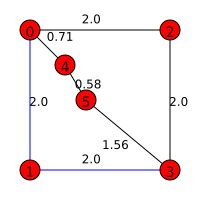

In [337]:
'''
TEST
When there are two equivalent paths in a graph, make sure that both of them, and not just one is returned
Let's change G_rect slightly, so that the perimeter paths are equivalent in terms of number of nodes and distance
'''

nodes       = [(0,1),(0,2),(2,3),(1,3),(0,4),(4,5),(5,3)]
coords      = [(0,0),(0,2),(2,0),(2,2),(0.5,0.5),(0.8,1)]
start_node  = 0
end_node    = 3

G_rect      = make_graph(nodes, coords)
nx_G_rect   = convert_to_nx(G_rect)                                 # converting the igraph object to a networkx object
end_goal    = nx_G_rect.nodes[end_node]['pos']
path_set    = list(nx.all_simple_paths(nx_G_rect, start_node, end_node)) # In this primitive example 
                                                                         # we consider path set as all possible paths 
                                                                         # but please use the cutoff parameter on a real dataset
print('path set:', path_set)
print('end goal' , end_goal)

print ('prioritising number of nodes: ');
path = choosePath_by_distance_and_NumberOfNodes(nx_G_rect, path_set, start_node, end_node, W_nodes=1)
print ('best path from ', start_node, " to ", end_node, ":" , path)
print ('\n\n');


G_rect.es['color']='black'
for i in range(len(path_set[best_path])-1):
    G_rect.es.find(_between = ((path_set[best_path][i],),(path_set[best_path][i+1],)) )['color'] = 'blue'

plot(G_rect, layout = coords, vertex_label= G_rect.vs['names'], edge_label=G_rect.es['names'], margin=30, bbox=(200,200))

# TODO: Only one path is returned, FIX THIS

In [ ]:
'''
TEST
When there are two equivalent paths in a graph, make sure that both of them, and not just one is returned
Let's change G_rect, so that proximity scored are equivalent for all three paths
TBD
'''

In [ ]:
'''
TEST
When there are two equivalent paths in a graph, make sure that both of them, and not just one is returned
Let's change G_rect, so that the distances are equivalent for all paths
TBD
'''

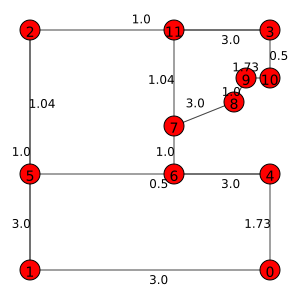

In [293]:
'''
Testing the three heuristics defined above behave on other examples
TBD - Please descrive what do you expect this example to show
'''

# Graph Example 2
h2_vs    = [(0,1),
            (1,2),(1,5),
            (2,3),(0,4),(4,5),(5,2),(4,6),(6,7),(7,8),(8,9),(9,10),(10,3),(7,11),(11,3)]
h2_ps    = [(10,10),(0,10),(0,0),(10,0),(10,6),(0,6),(6,6),(6,4),(8.5,3),(9,2),(10,2),(6,0)]
G_h2     = make_graph(h2_vs,h2_ps)

# MARTA: what is this ?
h2_vs_bi = [(0,1), 
            (2,11), # extra edges
            (1,5), (1,2),
            (2,1),(3,2), #extra edges
            (2,3),(0,4),(4,5),(5,2),(4,6),(6,7),(7,8),(8,9),(9,10),(10,3),(7,11),(11,3)] #for visualization purposes

G_h2_bi  = make_graph(h2_vs_bi, h2_ps ) #for visualization purposes

plot(G_h2, layout = h2_ps, vertex_label = G_h2.vs['names'], edge_label=G_rect.es['names'], margin=30, bbox=(300,300))

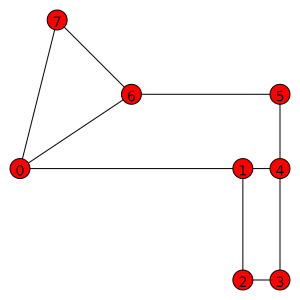

In [322]:
'''
Testing the three heuristics defined above behave on other examples
TBD - Please descrive what do you expect this example to show
'''

# Graph Example 3

h1_2_ps = [(-4,2),(8,2),(8,5),(10,5),(10,2),(10,0),(2,0),(-2,-2)]
h1_2_vs = [(0,1),(1,2),(2,3),(3,4),(4,5),(0,6),(6,5),(1,4),(7,0),(7,6)]
G_h12   = make_graph(h1_2_vs,h1_2_ps)
G_h12.es['color']='black'

#for i in range(len(path)-1):
#    G_h12.es.find(_between = ((path[i],),(path[i+1],)) )['color'] = 'blue'

plot(G_h12,layout = h1_2_ps, vertex_label=G_h12.vs['names'],margin=20, bbox=(300,300))

In [ ]:
'''
Testing on a real data-set.
TBD
'''

# 0. Load the dataset graph

# 1. Select a start and end node

# 2. Select a path set to be considered, using the cutoff parameter

# 3. 